<a href="https://colab.research.google.com/github/hinton024/Assignment-2-Social-media-and-network-analytics/blob/main/Youtube_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the Neccessary Libraries

In [6]:
!pip install langdetect
!pip install contractions
import pandas as pd
import re
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import nltk
from langdetect import detect, LangDetectException
import contractions
from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=991dc61fa4a38b2974648a2109c42aa24e5a13f09e4fd4d83d640c51e1b3cfdb
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.6 MB/s eta 0:00:00


### 1. Data Preprocessing
#### Loading the Data

In [7]:
with open('DB_youtube.json', 'r', encoding='utf-8') as file:
    youtube = json.load(file)

# Converting the data into a DataFrame
df = pd.DataFrame(youtube)
df.head()


,Title,Video ID,Published at,Description,Category ID,Comment Count,Comments
0,10 ICONIC David Beckham goals you'll NEVER forget,oTpTVqJX8ho,2023-12-11T16:01:00Z,10 of the best Premier League goals scored by ...,17,627,"[Favourite David Beckham goal?, Goals before I..."
1,"David Beckham SURPRISES Thierry Henry, Jamie C...",wFDSJuqg0Vk,2024-09-17T19:56:02Z,"David Beckham surprised Kate Abdo, Jamie Carra...",17,1822,"[MY HERO!!😂😂😂, As if David lets his mom cut hi..."
2,David Beckham Embraces the Moment While Eating...,igmUnkx0fBw,2024-08-29T15:00:45Z,David Beckham takes on the Hot Ones gauntlet f...,24,4265,[Yet further evidence that David Beckham is on...
3,David Beckham on Spice Girls Reuniting for Vic...,rniYjUoNbOU,2024-05-09T06:00:23Z,"David talks about his honey, owning the Miami ...",23,771,"[Amazing performance mate&#39;s, changed game...."
4,David Beckham sends touching message to MESSI ...,wHE7ZN50WSk,2024-10-04T07:00:12Z,"beckham messi inter miami,beckham messi reacti...",17,34,"[Aquì vuelvo a decirlo, ha sido muy raro que B..."


#### Check for Missing Values

In [8]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Display missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
Title            0
Video ID         0
Published at     0
Description      0
Category ID      0
Comment Count    0
Comments         0
dtype: int64


#### Check for Duplicate Values

In [9]:
# Check for duplicates based on Video ID
duplicates = df.duplicated(subset=['Video ID']).sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates if any
df.drop_duplicates(subset=['Video ID'], inplace=True)


Number of duplicate rows: 0


#### Advance Preprocessing

In [10]:
# Function for clean text
def clean_text(text):
    # Removing URLs and special characters, convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower().strip()

# Function to detect if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False


In [11]:
# Filtering out non-English titles, descriptions, and comments
df['Cleaned_Title'] = df['Title'].apply(lambda x: clean_text(str(x)) if is_english(str(x)) else '')
df['Cleaned_Description'] = df['Description'].apply(lambda x: clean_text(str(x)) if is_english(str(x)) else '')

# cleaning and filtering each comment within the list
df['Cleaned_Comments'] = df['Comments'].apply(lambda comments: [clean_text(comment) for comment in comments if is_english(comment)])

#### Expanding Contractions

In [12]:
# Expand contractions for each column separately
df['Expanded_Title'] = df['Cleaned_Title'].apply(contractions.fix)
df['Expanded_Description'] = df['Cleaned_Description'].apply(contractions.fix)
df['Expanded_Comments'] = df['Cleaned_Comments'].apply(lambda comments: [contractions.fix(comment) for comment in comments])

#### Tokenization

In [14]:
# Tokenizing the cleaned text
nltk.download('punkt')
df['Title_Tokens'] = df['Cleaned_Title'].apply(word_tokenize)
df['Description_Tokens'] = df['Cleaned_Description'].apply(word_tokenize)
df['Comments_Tokens'] = df['Cleaned_Comments'].apply(lambda comments: [word_tokenize(comment) for comment in comments])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Stopwords Removal

In [16]:
nltk.download('stopwords')
# Removal of Stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['Title_Tokens'] = df['Title_Tokens'].apply(remove_stopwords)
df['Description_Tokens'] = df['Description_Tokens'].apply(remove_stopwords)
df['Comments_Tokens'] = df['Comments_Tokens'].apply(lambda comments: [remove_stopwords(comment) for comment in comments])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Lemmatization

In [17]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df['Title_Tokens'] = df['Title_Tokens'].apply(lemmatize_tokens)
df['Description_Tokens'] = df['Description_Tokens'].apply(lemmatize_tokens)
df['Comments_Tokens'] = df['Comments_Tokens'].apply(lambda comments: [lemmatize_tokens(comment) for comment in comments])

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [18]:
# Printing the processed data
processed_columns = ['Title', 'Cleaned_Title', 'Title_Tokens', 'Description', 'Cleaned_Description', 'Description_Tokens', 'Comments', 'Cleaned_Comments', 'Comments_Tokens']
print("\nProcessed Data:")
print(df[processed_columns].head(5))


Processed Data:
                                               Title  \
0  10 ICONIC David Beckham goals you'll NEVER forget   
1  David Beckham SURPRISES Thierry Henry, Jamie C...   
2  David Beckham Embraces the Moment While Eating...   
3  David Beckham on Spice Girls Reuniting for Vic...   
4  David Beckham sends touching message to MESSI ...   

                                       Cleaned_Title  \
0                                                      
1  david beckham surprises thierry henry jamie ca...   
2  david beckham embraces the moment while eating...   
3  david beckham on spice girls reuniting for vic...   
4  david beckham sends touching message to messi ...   

                                        Title_Tokens  \
0                                                 []   
1  [david, beckham, surprises, thierry, henry, ja...   
2  [david, beckham, embraces, moment, eating, spi...   
3  [david, beckham, spice, girls, reuniting, vict...   
4  [david, beckham, sends, to

#### Term Frequency

In [19]:
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

# Function to process text: tokenize, remove stopwords, and lemmatize
def process_text(text, lemmatizer, stopwords_set):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [21]:
nltk.download('wordnet')
term_freq_counter = Counter()

# Processing each row in the DataFrame and update term frequency counts
for _, row in df.iterrows():
    tokens_title = process_text(row['Cleaned_Title'], lemmatizer, stopwords_set)
    tokens_description = process_text(row['Cleaned_Description'], lemmatizer, stopwords_set)
    tokens_comments = [word for comment in row['Cleaned_Comments'] for word in process_text(comment, lemmatizer, stopwords_set)]

    term_freq_counter.update(tokens_title)
    term_freq_counter.update(tokens_description)
    term_freq_counter.update(tokens_comments)

# Display the most common terms
freq_num = 50  # Number of most frequent terms to display
print(f"Top {freq_num} most common terms:")
for term, count in term_freq_counter.most_common(freq_num):
    print(f"{term}: {count}")

[nltk_data] Downloading package wordnet to /root/nltk_data...


Top 50 most common terms:
beckham: 361
david: 266
like: 204
one: 177
player: 152
man: 152
love: 146
football: 113
time: 104
great: 91
good: 89
best: 87
he: 87
world: 85
never: 85
would: 85
know: 80
real: 78
get: 76
people: 76
legend: 73
game: 72
show: 72
guy: 71
england: 70
href: 69
dont: 69
even: 67
see: 67
u: 64
year: 64
goal: 63
play: 63
really: 63
team: 62
ever: 61
look: 61
messi: 61
got: 60
always: 60
ball: 58
much: 58
kick: 57
still: 57
well: 56
respect: 51
thats: 50
free: 50
fan: 50
im: 50


# WordCloud of Sentiment Heavy Words and Entities

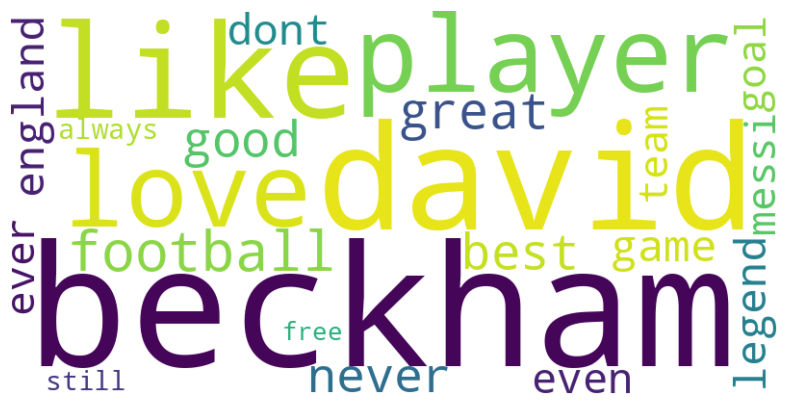

In [22]:
# Visualizing the sentiment heavy words and entities
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionary with sentiment heavy words and entities and their frequencies as values
words_freq = {
    "beckham": 364,
    "david": 268,
    "like": 208,
    "player": 152,
    "love": 147,
    "football": 113,
    "great": 90,
    "good": 88,
    "best": 87,
    "never": 85,
    "game": 72,
    "england": 70,
    "legend": 70,
    "dont": 70,
    "even": 66,
    "goal": 63,
    "team": 62,
    "messi": 61,
    "ever": 60,
    "always": 59,
    "still": 56,
    "free": 50
}

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)

# Plotting the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hiding axes
plt.show()


# Bar Chart of Sentiment Heavy Words and Entities with their frequencies

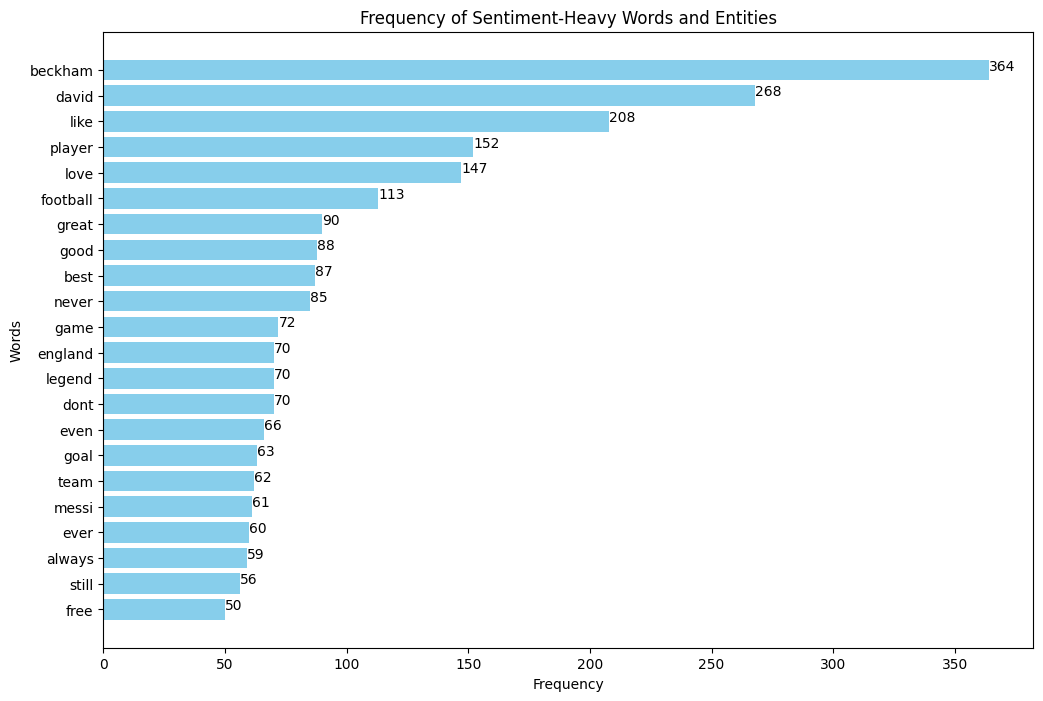

In [23]:
# Visualizing the sentiment heavy words and entities and their frequencies as values

# List of words and their frequencies
words = [
    "beckham", "david", "like", "player", "love", "football", "great", "good",
    "best", "never", "game", "england", "legend", "dont",
    "even", "goal", "team", "messi", "ever", "always", "still", "free"
]

frequencies = [
    364, 268, 208, 152, 147, 113, 90, 88,
    87, 85, 72, 70, 70, 70,
    66, 63, 62, 61, 60, 59, 56, 50
]

# Plotting the bar chart
plt.figure(figsize=(12,8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency of Sentiment-Heavy Words and Entities')
plt.gca().invert_yaxis()  # Inverting y axis to have the most frequent word on top

# Adding frequencies next to the bars  # Adding frequencies next to the bar
for index, value in enumerate(frequencies):
    plt.text(value, index, str(value))
plt.show()

# Tfidf Vectorization

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for Pre-processing text by removing numbers
def preprocess_text(text):
    return re.sub(r'\d+', '', text)

# loading data from json file
with open('DB_youtube.json', 'r', encoding='utf-8') as f:
    posts_data = json.load(f)

    comments = []
    for post in posts_data:
        for comment in post['Comments']:
            preprocessed_comment = preprocess_text(comment)  # Preprocessing the comments
            comments.append(preprocessed_comment)  # Storing preprocessed comments

# Converting the comments into a dataframe
df = pd.DataFrame(comments, columns=['Cleaned_Comments'])

# Checking the dataframe
print("DataFrame preview (first 5 rows):")
print(df.head())

# Adjusting the token pattern to exclude purely numerical tokens and refining the ngram range
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',  # Excludes purely numeric tokens and requires at least three characters
    ngram_range=(1,2),  #unigram and bi-gram
    min_df=10,  # Increase min_df to reduce features that appear rarely
    max_df=0.5 # Lower max_df to exclude terms that are too common

)

# Fitting and transforming the comments into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Comments']).toarray()

# Converting to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

DataFrame preview (first 5 rows):
                     Cleaned_Comments
0       Favourite David Beckham goal?
1  Goals before I was born..Beckham❤❤
2      Clearly not just a pretty face
3    greatest of his generation.... ❤
4   Bald beckham at United was scary.
   absolute  absolutely  act  actually  age  amazing  amp  awesome  bad  ball  \
0       0.0         0.0  0.0       0.0  0.0      0.0  0.0      0.0  0.0   0.0   
1       0.0         0.0  0.0       0.0  0.0      0.0  0.0      0.0  0.0   0.0   
2       0.0         0.0  0.0       0.0  0.0      0.0  0.0      0.0  0.0   0.0   
3       0.0         0.0  0.0       0.0  0.0      0.0  0.0      0.0  0.0   0.0   
4       0.0         0.0  0.0       0.0  0.0      0.0  0.0      0.0  0.0   0.0   

   ...  www  www youtube  yeah  year  years  yes  young  youtube  youtube com  \
0  ...  0.0          0.0   0.0   0.0    0.0  0.0    0.0      0.0          0.0   
1  ...  0.0          0.0   0.0   0.0    0.0  0.0    0.0      0.0          0.0   
2  ...  

# Vader Sentiment Analysis

In [26]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initializing VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis with error handling
def analyze_sentiment(text):
    if text:  # Checking if text is not empty or None
        try:
            sentiment = analyzer.polarity_scores(text)
            return sentiment['compound']  # Compund score represents overall sentiment
        except Exception as e:
            print(f"Error analyzing sentiment: {e}")
            return None  # Return None if there's an error
    else:
        return None  # Return None for empty or None text

# Applying sentiment analysis
df['sentiment_score'] = df['Cleaned_Comments'].apply(analyze_sentiment)

# Categorize sentiment based on the score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Printing results
print("DataFrame with sentiment scores and categories (first 5 rows):")
print(df[['Cleaned_Comments', 'sentiment_score', 'sentiment_category']].head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00
DataFrame with sentiment scores and categories (first 5 rows):
                     Cleaned_Comments  sentiment_score sentiment_category
0       Favourite David Beckham goal?           0.0000            neutral
1  Goals before I was born..Beckham❤❤           0.8555           positive
2      Clearly not just a pretty face           0.0186            neutral
3    greatest of his generation.... ❤           0.8555           positive
4   Bald beckham at United was scary.          -0.1027           negative


#  Visualizing sentiment score distribution by histogram and density plot

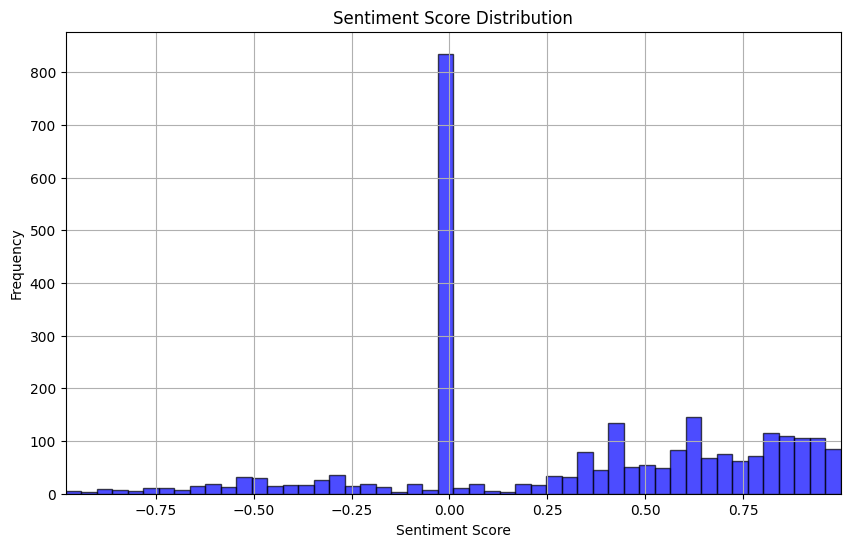

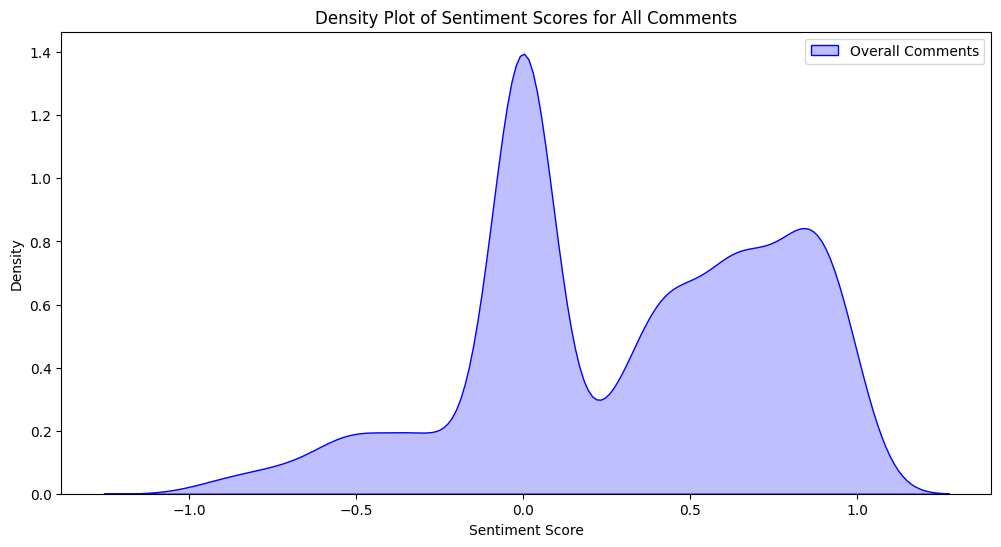

In [27]:
#Visualizing sentiment score distribution by histogram and density plot

num_bins = 50  # Number of bins

# Plotting sentiment score distribution
plt.figure(figsize=(10,6))
plt.hist(df['sentiment_score'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.grid(True)   # For better readability

# Setting plot titles and labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')

# Setting x and y limits
plt.xlim(df['sentiment_score'].min(), df['sentiment_score'].max())
plt.ylim(0, plt.ylim()[1])  # Ensuring y axis starts from 0 and is correclty scaled

plt.show()


# Plotting density of sentiment scores for all comments
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df['sentiment_score'], fill=True, color='blue', label='Overall Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores for All Comments')
plt.legend()
plt.show()

# Word Cloud for overall comments

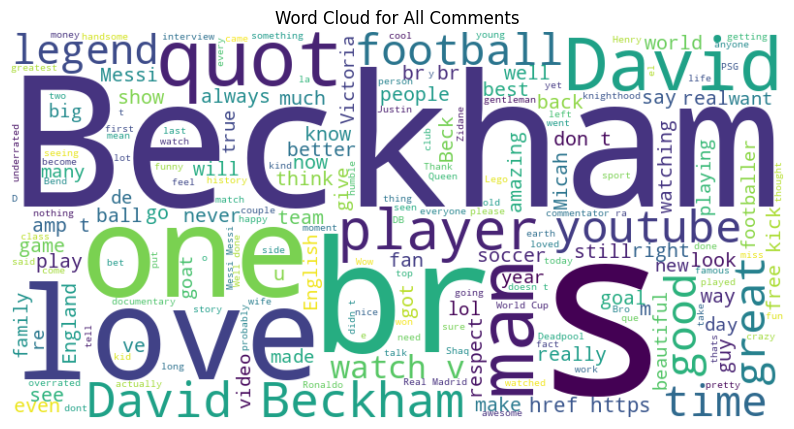

In [28]:
# Word Cloud for overall comments

from wordcloud import WordCloud, STOPWORDS
all_comments = ' '.join(df['Cleaned_Comments'])

# Generating word cloud with custom settings
wordcloud = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=set(STOPWORDS), max_words=200, colormap='viridis'
).generate(all_comments)

# Displaying the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Word Cloud for All Comments')
plt.show()


### LDA Model

### Plotting coherence term plot to determine optimal number of topics

['Favourite David Beckham goal?', 'Goals before I was born..Beckham❤❤', 'Clearly not just a pretty face', 'greatest of his generation.... ❤', 'Bald beckham at United was scary.', 'the one was uploaded twice here', '<a href="https://www.youtube.com/watch?v=oTpTVqJXho&amp;t=">:</a> That’s a truly elegant goal, that’s the best way to describe it.', 'underrated as fuck', '✋🤚😉cc', 'British 🐐', 'Should&#;ve included his free kick in  world cup&#;s quarter finals', 'Becks scores only bangers', 'MAGNIFICENT 💯👍', '“If anyone can go to the Brazilian national team it’s got to be David Beckham,”', '<a href="https://www.youtube.com/watch?v=oTpTVqJXho&amp;t=">:</a> Haaland?', 'Saya suka, cara dia mengancang-ancang sebelum bola di tendang', 'Becks is the reason i love footbal and be a united fans❤', 'Stick with ra if you like your bets fair and your winnings even fairer.', 'Always a fair game with ra, they really know how to treat bettors right.', 'Nothing beats the thrill of betting with ra, where t

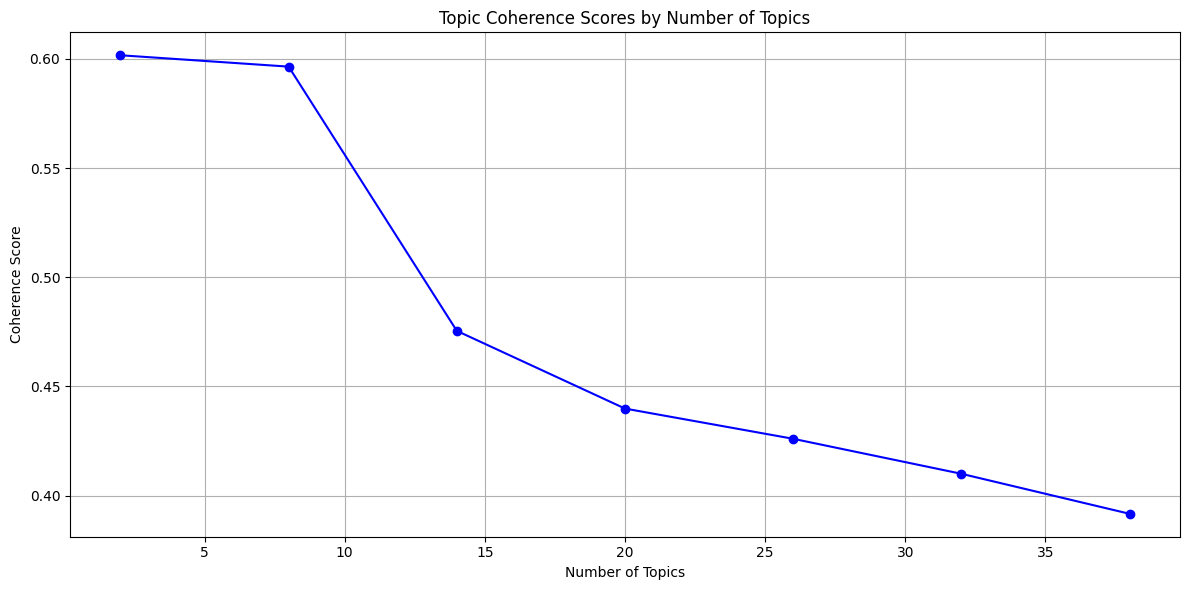

Optimal number of topics: 2


In [29]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np

# Extracting 'Cleaned_Comments' from the DataFrame
lPosts = df['Cleaned_Comments'].tolist()
print(lPosts)
data = [post.split() for post in lPosts]

# Create Dictionary and Corpus (this part remains the same)
id2word = corpora.Dictionary(data)
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

def compute_coherence_for_model(params):
    """Compute coherence for a single model"""
    num_topics, dictionary, corpus, texts = params
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """Compute coherence values for multiple models in parallel"""
    pool = Pool(processes=cpu_count())
    coherence_values = pool.map(
        compute_coherence_for_model,
        [(num_topics, dictionary, corpus, texts) for num_topics in range(start, limit, step)]
    )
    pool.close()
    pool.join()
    return coherence_values

# Set parameters
start, limit, step = 2, 40, 6

# Compute coherence values
coherence_values = compute_coherence_values(id2word, corpus, texts, start, limit, step)

# Plot results
x = range(start, limit, step)
plt.figure(figsize=(12, 6))
plt.plot(x, coherence_values, 'bo-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Topic Coherence Scores by Number of Topics")
plt.grid(True)
plt.tight_layout()
plt.show()

# Find optimal number of topics
optimal_num_topics = x[np.argmax(coherence_values)]
print(f'Optimal number of topics: {optimal_num_topics}')


In [41]:
# number of topics to discover (default = 10)
topicNum = 10
# maximum number of words to display per topic (default = 10)
# Answer to Exercise 1 (change from 10 to 15)
wordNumToDisplay = 10
# this is the number of features/words to used to describe our documents
# please feel free to change to see effect
featureNum = 1500

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Performs counting via CountVectorizer and then apply the LDA model.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lPosts)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualising topics

In [43]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Diplays discovered topics.

In [44]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
best world better overrated la kick free que goat el
Topic 1:
br like beckham messi play think big david old micah
Topic 2:
br football great did really know real don right ve
Topic 3:
quot watch amp youtube com www href https thank said
Topic 4:
time becks gentleman does bro deadpool captain wrong true royal
Topic 5:
legend game club fans way miss ich wife support greece
Topic 6:
years lol ra got want just miami awesome spice day
Topic 7:
beckham david good love team class man player say england
Topic 8:
william prince english left posh king fact won underrated face
Topic 9:
man like just people guy love player david amazing looks


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne') # Use lda_model for prepare
pyLDAvis.display(panel)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
